In [1]:
#Import required libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np

In [2]:
IMAGE_SIZE = 224 #our input images are 500*500*3 we rescale them to 224*224*3 so we can use mobilenetv2
BATCH_SIZE = 32

In [3]:
#lets load the tf dataset using api. This function loads images from our specified directory and convert images to tensors
#having rgb values of each image and extracts the label for it.
#tf dataset to take datasets as bunch
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 1295 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [7]:
dataset.take(1)

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

(32, 224, 224, 3)


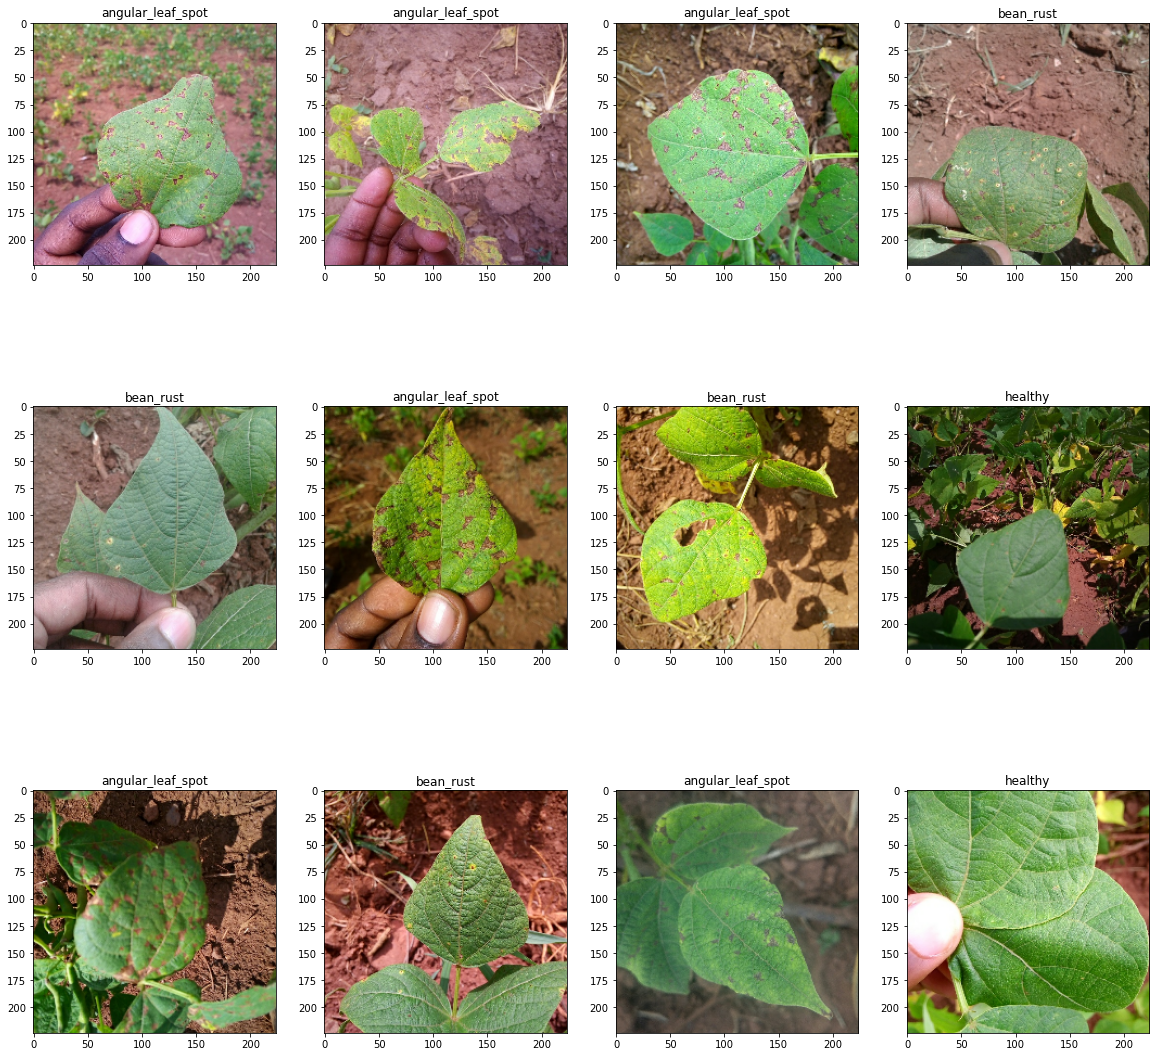

In [8]:
plt.figure(figsize = (20,20)) # Lets increse plot size of our plots
# display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot 
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) 
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)

In [9]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[432 436 427]


In [10]:
def get_partition(ds,train_split = 0.7, validate = 0.2,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        train_size = int(train_split*ds_size)
        val_size = int(validate*ds_size)
        train = ds.take(train_size)
        val = ds.skip(train_size).take(val_size)
        test = ds.skip(train_size).skip(val_size)
        return train,val,test  

In [11]:
train,val,test = get_partition(dataset)

In [12]:
len(train)

28

In [13]:
#It will read the image from the disk and for next iteration if you need the same image it will keep that image in memory
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
#data augmentation : taking one image rotate-flip do all those things train each of that, so that efficiency is increased
data_augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train = train.map(lambda x, y: (data_augment(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
IMG_SHAPE =  (224,224)+ (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


In [23]:
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")

In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843  

In [27]:
history = model.fit(train,epochs=30,validation_data=val, batch_size = 32, verbose =1)

Epoch 1/30
28/28 [==============================] - 32s 1s/step - loss: 1.0237 - accuracy: 0.5127 - val_loss: 0.6498 - val_accuracy: 0.7500
Epoch 2/30
28/28 [==============================] - 25s 905ms/step - loss: 0.5715 - accuracy: 0.7457 - val_loss: 0.5323 - val_accuracy: 0.7852
Epoch 3/30
28/28 [==============================] - 25s 906ms/step - loss: 0.5169 - accuracy: 0.7901 - val_loss: 0.4777 - val_accuracy: 0.8203
Epoch 4/30
28/28 [==============================] - 25s 904ms/step - loss: 0.4461 - accuracy: 0.8380 - val_loss: 0.4324 - val_accuracy: 0.8398
Epoch 5/30
28/28 [==============================] - 25s 907ms/step - loss: 0.3998 - accuracy: 0.8500 - val_loss: 0.4205 - val_accuracy: 0.8008
Epoch 6/30
28/28 [==============================] - 25s 900ms/step - loss: 0.3475 - accuracy: 0.8540 - val_loss: 0.4141 - val_accuracy: 0.8398
Epoch 7/30
28/28 [==============================] - 25s 904ms/step - loss: 0.3764 - accuracy: 0.8562 - val_loss: 0.3576 - val_accuracy: 0.8555
Ep

In [28]:
scores = model.evaluate(test)

5/5 [==============================] - 7s 538ms/step - loss: 0.2217 - accuracy: 0.9250


In [29]:
scores

[0.22165553271770477, 0.925000011920929]

In [30]:
history
#search in google tensorflow.python.keras.callback.History in google 

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 28}

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

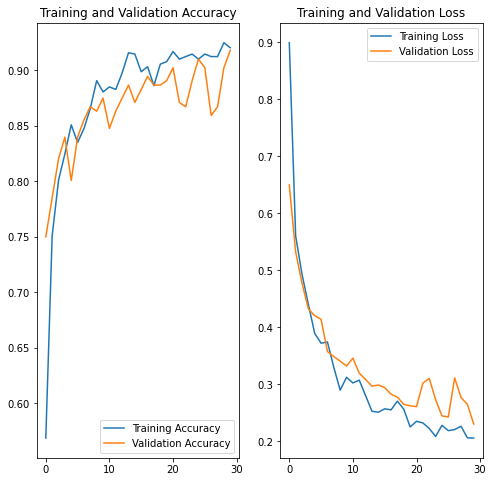

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: bean_rust
predicted label: bean_rust


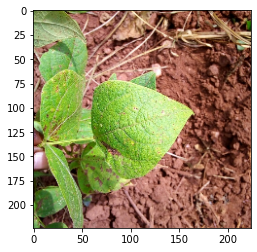

In [34]:
import numpy as np
for images_batch, labels_batch in test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

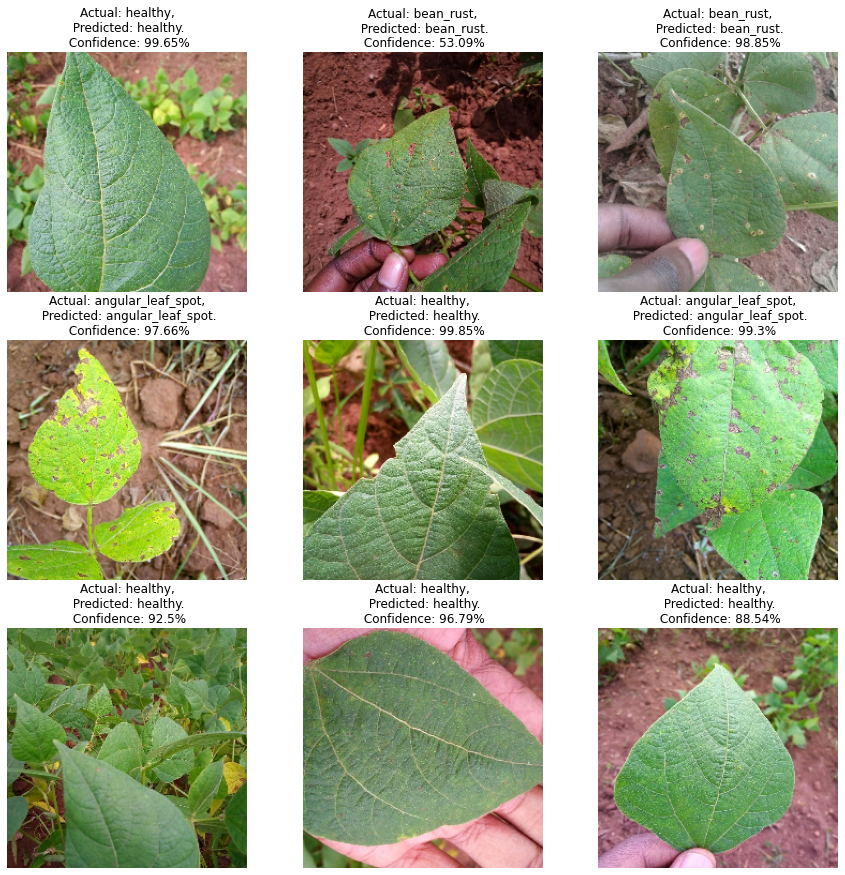

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class

In [38]:
count=0
predict_valid=[]
actual_valid=[]
for images, labels in val:
    for i in range(32):
        if(count!=2160): 
            predicted_class=predict(model, images[i].numpy())
            predict_valid.append(predicted_class)
            actual_valid.append(class_names[labels[i]])
            count+=1
print(actual_valid[100:105])

['angular_leaf_spot', 'healthy', 'bean_rust', 'angular_leaf_spot', 'bean_rust']


In [39]:
print(predict_valid[0:5])

['bean_rust', 'angular_leaf_spot', 'bean_rust', 'angular_leaf_spot', 'bean_rust']


In [40]:
print(actual_valid[0:5])

['bean_rust', 'angular_leaf_spot', 'bean_rust', 'angular_leaf_spot', 'bean_rust']


In [41]:
from sklearn import metrics
report = metrics.classification_report(actual_valid, predict_valid,target_names=dataset.class_names)
print(report) 

                   precision    recall  f1-score   support

angular_leaf_spot       0.93      0.90      0.92        91
        bean_rust       0.86      0.88      0.87        75
          healthy       0.96      0.97      0.96        90

         accuracy                           0.92       256
        macro avg       0.92      0.92      0.92       256
     weighted avg       0.92      0.92      0.92       256



In [42]:
model.save('bean_disease_classifier_model_MobileNetv2.hdf5')